# Modelo preditivo
***

Neste dataset, o objetivo é prever o valor da mediana dos preços da casa na área de California. As features coletadas se baseam no estado real e informação geográfica.

Como o objetivo é prever um valor contínuo, esta tarefa é de regressão.

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

In [2]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Para facilitar futura visualização, vamos transformar os preços de dólar($) para (k$).

In [4]:
target *= 100
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

## Erro de treinamento vs erro de teste.

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import set_config
set_config(display='diagram')

tree_reg = DecisionTreeRegressor(random_state=0)
tree_reg.fit(data, target)

DecisionTreeRegressor(random_state=0)

Depois de treinar o modelo, queremos avaliar a performance estatística antes de colocar o modelo em produção. Para isso vamos usar a métrica **mean absolute error**, que nos dá o erro na unidade nativa do variável target, que aqui será (k$).
*erro médio absoluto expressa o erro de previsão médio absoluto do modelo. Se quisermos ignorar os outliers, é uma boa métrica para ser usada.

In [6]:
from sklearn.metrics import mean_absolute_error

target_predicted = tree_reg.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"Na média, nosso regressor erra por {score:.2f} k$")

Na média, nosso regressor erra por 0.00 k$


O erro computado acima é chamado de erro empirico ou erro de treinamento.

Nos treinamos um modelo preditivo para minimizar o erro de treinamento, mas nosso objetivo é minimizar o erro nos dados não vistos na etapa de treinamento.

Esse erro é chamado de erro de generalização ou "true" **erro de teste**.

### Avaliação de modelo envolve(steps):
***

* dividir o dataset em 2 subsets: conj. treinamento e conj. teste
* treinar o modelo no conjunto de treinamento.
* estimação do erro de treinamento calculado no conjunto de treinamento.
* estimação do erro de teste calculado no conjunto de teste

Dividir os dados em treinamento e teste:

In [7]:
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(data, target, random_state = 0)

In [8]:
tree_reg.fit(data_train, target_train)
tree_reg

DecisionTreeRegressor(random_state=0)

In [10]:
target_predicted = tree_reg.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"O erro de treinamento do nosso modelo é: {score:.2f} k$")

O erro de treinamento do nosso modelo é: 0.00 k$


Observamos a mesma solução anterior, o que indica que nosso modelo memorizou os dados. Vamos computar o erro de teste para ver o que obtemos.

In [11]:
target_predicted = tree_reg.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"O erro de teste do nosso modelo é: {score:.2f} k$")

O erro de teste do nosso modelo é: 47.28 k$


O erro com respeito ao conjunto de teste é o que esperaríamos do nosso modelo em um ambiente de produção.

### Estabilidade da validação cruzada
***

Quando executamos uma simples divisão train-test nós não temos nenhuma indicação com respeito a robustez da avaliação do nosso modelo preditivo: em particular, se o conjunto de teste é pequeno, a estimação do erro de teste será instável e não refletirá a verdadeira taxa de erro que poderia ser observado com o mesmo modelo em uma quantidade ilimitada de dados para teste.

Ou poderíamos ter sorte e na nossa divisão aleatória do nosso dataset limitado, e conseguirmos somente casos simples para prever no conjunto de teste, apenas por chance. A estimação do erro não refletiria  a realidade e seria otimista.

**Cross-validation** permitir estimar a robustez do modelo preditivo repetindo o procedimento de divisão. Isso daria muitos conjuntos de treinamento/teste para avaliar os erros associados e então teríamos como estimar a variabilidade da performance estatística do nosso modelo.

In [12]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    tree_reg, data, target, cv=cv, scoring="neg_mean_absolute_error")

In [14]:
import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score
0,0.192168,0.004492,-46.909797
1,0.159771,0.006127,-46.421170
2,0.172655,0.005598,-47.411089
3,0.178934,0.005662,-44.319824
4,0.173069,0.004647,-47.607875


Uma pontuação(score) é uma métrica para a qual valores mais altos significam melhores resultados. Pelo contrário, um erro é uma métrica para a qual valores mais baixos significam melhores resultados. A pontuação de parâmetro em cross_validate sempre espera uma função que seja uma pontuação.

Para facilitar, todas as métricas de erro no scikit-learn, como mean_absolute_error, podem ser transformadas em uma pontuação a ser usada em cross_validate. Para fazer isso, você precisa passar uma string da métrica de erro com uma string neg_ adicional na frente para a pontuação do parâmetro; por exemplo scoring = "neg_mean_absolute_error". Neste caso, o negativo do erro absoluto médio será calculado, o que seria equivalente a uma pontuação.

Vamos reverter a negação para pegar o erro atual.

In [15]:
cv_results['test_error'] = -cv_results['test_score']
cv_results.head()

,fit_time,score_time,test_score,test_error
0,0.192168,0.004492,-46.909797,46.909797
1,0.159771,0.006127,-46.421170,46.421170
2,0.172655,0.005598,-47.411089,47.411089
3,0.178934,0.005662,-44.319824,44.319824
4,0.173069,0.004647,-47.607875,47.607875


Nós podemos ler no dataframe acima, o tempo de treinamento de cada fold, predição de cada iteração da validação cruzada. Como também podemos pegar o score de teste que corresponde ao erro de teste em cada fold.

Podemos usar os folds da validação cruzada para olhar os erros de teste e através da análise visual da sua distribuição estimar a variabilidade.


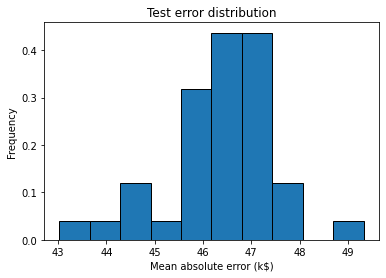

In [16]:
import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black", density=True)
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")

Podemos observar que o erro no conjunto de teste é centralizado ao redor de $47 k$ USD e varia entre 43 k$ a 50 k$.

In [17]:
print(f"A média do erro de teste na validação cruzada é: {cv_results['test_error'].mean():.2f} k$")

A média do erro de teste na validação cruzada é: 46.36 k$


In [18]:
print(f"O desvio padrão do erro de teste é: {cv_results['test_error'].std():.2f} k$")

O desvio padrão do erro de teste é: 1.17 k$


Podemos notar que o desvio padrão do erro de teste é bem menor que a média do erro. Poderíamos comparar o erro de teste com a variabilidade natural do nosso target do dataset.

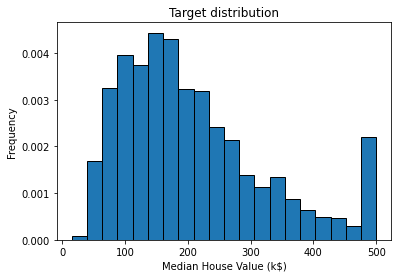

In [19]:
target.plot.hist(bins=20, edgecolor="black", density=True)
plt.xlabel("Median House Value (k$)")
_ = plt.title("Target distribution")

In [20]:
print(f"O desvio padrão do target é :{target.std():.2f} k$")

O desvio padrão do target é :115.40 k$


Considerando o erro a média do erro obtido com validação cruzada que foi de $47 k$ USD, não é um problema qdo estivermos prevendo casas no valor de 500 k$, mas é um problema qdo o valor da casa é de 50 k$, o que nos indica que o erro médio absoluto não é a métrica ideal para esse problema. Podemos usar uma métrica relativa o valor do target da previsão, mean absolute percentage error seria uma melhor escolha.

De qualquer maneira um erro de 47 k$ é muito grande para que usemos o nosso modelo para prever os valores dos preços das casas sem a supervisão de um expert do assunto.

In [21]:
cv_results = cross_validate(tree_reg, data, target, return_estimator=True)
cv_results

{'fit_time': array([0.19787955, 0.17467546, 0.17885065, 0.18902946, 0.1793077 ]),
 'score_time': array([0.00459528, 0.00373554, 0.00482488, 0.00359917, 0.00374126]),
 'estimator': [DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0)],
 'test_score': array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])}

In [22]:
cv_results["estimator"]

[DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0)]

Ter acesso aos regressores é útil porque permite a inspeção dos valores internos do fit destes regressores.

In [24]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, data, target)
scores

array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])

In [25]:
data.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [27]:
target[:5]

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

In [28]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
data.dtypes

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

In [33]:
linear_model = make_pipeline(
    StandardScaler(),
    LinearRegression()
)
linear_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [34]:
print(f"Pipeline steps:\n{linear_model.steps}")

Pipeline steps:
[('standardscaler', StandardScaler()), ('linearregression', LinearRegression())]


In [35]:
_ = linear_model.fit(data_train, target_train)

In [37]:
cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    linear_model, data, target, cv=cv, scoring="neg_mean_squared_error")

In [38]:
# Pontuação nos conjuntos de teste dos splits
cv_results = pd.DataFrame(cv_results)
cv_results.head(10)

,fit_time,score_time,test_score
0,0.019795,0.004131,-5431.489670
1,0.020151,0.005701,-5379.547943
2,0.020127,0.005929,-5458.188203
3,0.019619,0.012556,-4922.420431
4,0.029997,0.014753,-5219.908777
5,0.046217,0.011139,-5258.556051
6,0.041705,0.027967,-5335.972492
7,0.054723,0.013320,-5232.386115
8,0.045856,0.013564,-5257.945324
9,0.066518,0.045224,-5630.336054


In [39]:
cv_results['test_error'] = -cv_results['test_score']
cv_results.head(10)

,fit_time,score_time,test_score,test_error
0,0.019795,0.004131,-5431.489670,5431.489670
1,0.020151,0.005701,-5379.547943,5379.547943
2,0.020127,0.005929,-5458.188203,5458.188203
3,0.019619,0.012556,-4922.420431,4922.420431
4,0.029997,0.014753,-5219.908777,5219.908777
5,0.046217,0.011139,-5258.556051,5258.556051
6,0.041705,0.027967,-5335.972492,5335.972492
7,0.054723,0.013320,-5232.386115,5232.386115
8,0.045856,0.013564,-5257.945324,5257.945324
9,0.066518,0.045224,-5630.336054,5630.336054


In [41]:
print(f"A média do erro no conjunto de teste usando validação cruzado do modelo linear é:\
      \n{cv_results['test_error'].mean():.3f} +/- {cv_results['test_error'].std():.3f} k$")

A média do erro no conjunto de teste usando validação cruzado do modelo linear é:      
5300.185 +/- 149.455 k$


In [47]:
print(f"O total de features no dataset analisado : {data.shape[1]}")

O total de features no dataset analisado : 8


In [42]:
print(f"Pipeline steps:\n{linear_model.steps}")

Pipeline steps:
[('standardscaler', StandardScaler()), ('linearregression', LinearRegression())]


In [48]:
coeficientes = linear_model.named_steps['linearregression'].coef_
print(f"Os pesos das características(coeficientes) da regressão linear do modelo são: \n{coeficientes}")

Os pesos das características(coeficientes) da regressão linear do modelo são: 
[ 83.18994482  12.09374001 -26.17515663  30.40521224  -0.87355926
  -2.98444244 -89.23653827 -86.38503112]


In [50]:
linear_model.named_steps['linearregression'].coef_.shape

(8,)

In [53]:
valor_medio_esperado = linear_model.named_steps['linearregression'].intercept_

In [55]:
print(f"O valor médio do target usando a regressão linear ou a interseção com o eixo Y é: \
    {valor_medio_esperado:.2f} k$")

O valor médio do target usando a regressão linear ou a interseção com o eixo Y é:     207.44 k$


In [57]:
r2_test = linear_model.score(data_test, target_test)
print(f"O score do conj. de teste usando estimador linear é: {r2_test:.3f}")

O score do conj. de teste usando estimador linear é: 0.591


In [58]:
r2_test_tree = tree_reg.score(data_test, target_test)
print(f"O score do conj. de teste usando estimador de decision tree é: {r2_test_tree:.3f}")

O score do conj. de teste usando estimador de decision tree é: 0.584


Os coeficientes de regressão vistos individualmente como atributos do pipeline, explicam o valor esperado(model.intercept_) e como os atributos (pesos) que causam impacto na predição. Um coeficiente positivo indica que, à medida que o valor de um atributo aumenta, o mesmo ocorrerá com a predição.

Para melhor entender a performance estatística dos nosso modelos e achar insights de como melhora-lo, nós iremos comparar os erros de treinamento com os erros de teste. Para isso vamos computar o erro de treinamento usando a função de validação cruzada(**cross_validate()**)

In [61]:
# Decision tree
tree_reg=DecisionTreeRegressor(random_state=0)
cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results_tree = cross_validate(tree_reg, data, target,
                            cv=cv, scoring="neg_mean_squared_error", # RMSE
                            return_train_score=True, n_jobs=-1)
cv_results_tree = pd.DataFrame(cv_results_tree)

A validação cruzada usa o valor negativo da erro quadrático médio (**neg_mean_squared_error**). Nós transformamos o RMSE negativo em RMSE positivo, fazendo:

In [63]:
scores_tree = pd.DataFrame()
scores_tree[['train error', "test error"]] = -cv_results_tree[['train_score', "test_score"]]

scores_tree.head(10)

,train error,test error
0,5.287447e-28,5347.887133
1,1.952500e-26,5285.880631
2,4.201388e-28,5340.018578
3,1.387906e-26,5043.049351
4,4.778663e-28,5101.186329
5,1.957901e-26,5025.207834
6,1.482951e-26,5159.656132
7,5.537926e-28,5182.443640
8,2.075998e-26,5290.819527
9,4.796274e-28,5443.965406


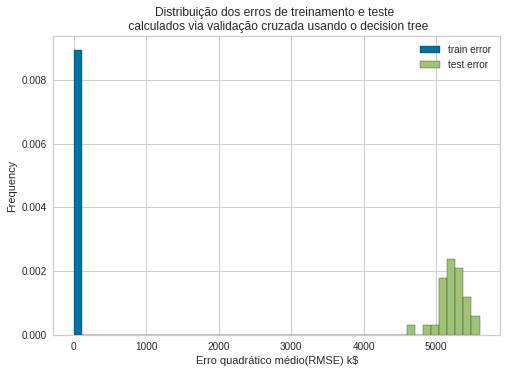

In [65]:
scores_tree.plot.hist(bins=50, edgecolor='k', density=True)
plt.xlabel("Erro quadrático médio(RMSE) k$")
_ = plt.title("Distribuição dos erros de treinamento e \
    teste \n calculados via validação cruzada usando o decision tree")

Plotando a distribuição dos erros de treinamento e teste, nós pegamos a informação se o modelo está sofrendo de "overfitting", "underfitting" ou ambos ao mesmo tempo.

No modelo de decision tree, vemos um pequeno erro de treinamento(aproximadamente zero), significando que o modelo não está sofrendo de "overfitting". É flexível o suficiente para capturar qualquer variação presente no conjunto de treinamento.

Contudo o grande erro de teste, nos diz que o modelo está sofrendo de "overfitting", ou seja, o modelo memorizou as muitas variações presentes no conjunto de treinamento que podem ser consideradas como "ruídos" e que não ajudam a generalizar para ajudar nas predições do conjunto de teste.

In [66]:
# Modelo Linear

cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results_lr = cross_validate(linear_model, data, target,
                            cv=cv, scoring="neg_mean_squared_error", # RMSE
                            return_train_score=True, n_jobs=-1)
cv_results_lr = pd.DataFrame(cv_results_lr)

scores_lr = pd.DataFrame()
scores_lr[['train error', "test error"]] = -cv_results_lr[['train_score', "test_score"]]

scores_lr.head(10)

,train error,test error
0,5269.128900,5150.584358
1,5319.374019,4944.347098
2,5334.175578,5087.355390
3,5208.979975,5387.308609
4,5207.715798,5450.414076
5,5213.014427,5369.134635
6,5185.900728,5477.192096
7,5225.511425,5340.656161
8,5261.177635,5309.835606
9,5251.782949,5212.370404


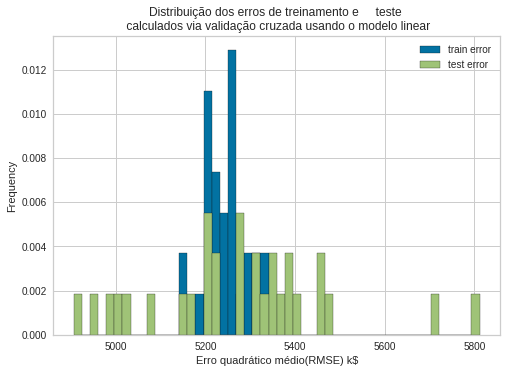

In [67]:
scores_lr.plot.hist(bins=50, edgecolor='k', density=True)
plt.xlabel("Erro quadrático médio(RMSE) k$")
_ = plt.title("Distribuição dos erros de treinamento e \
    teste \n calculados via validação cruzada usando o modelo linear")

Usando o modelo linear, percebemos que os erros de treinamento, e os erros de teste são altos, o que nos informa que esse não é um modelo que pode ser usado, o modelo sofre de overfitting e underfitting ao mesmo tempo.

### Curva de validação
Alguns hiperparâmetros de um modelo são a chave para sair de modelo que está underfitting para um modelo que overfitting, e talvez achar um bom balanço entre os dois. Nós podemos adquirir conhecimento sobre essas informações usando a curva de validação.

Para um decision tree, o parâmetro max_depth é usado para controlar o tradeoff entre o underfitting e overfitting.

In [68]:
%%time
from sklearn.model_selection import validation_curve

max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
    tree_reg, data, target, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="neg_mean_squared_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

CPU times: user 583 ms, sys: 73.7 ms, total: 657 ms
Wall time: 17.7 s


Text(0, 0.5, 'Erro médio quadrático(k$)')

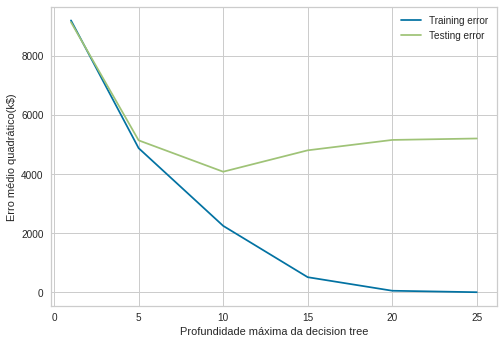

In [69]:
plt.plot(max_depth, train_errors.mean(axis=1), label="Training error")
plt.plot(max_depth, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Profundidade máxima da decision tree")
plt.ylabel("Erro médio quadrático(k$)")

Podemos dividir o gráfico em 3 áreas básicas:

* max_depth < 10, a decision tree underfits. O erro de treinamento e de teste são ambos altos. O modelo tem muitas restrições e não consegue capturar a variabilidade do variável target.
* a região em torno de max_depth = 10 corresponde ao parâmetro qual o decision tree generaliza melhor. É flexível o suficiente para capturar a fração da variabilidade do alvo, enquanto não generaliza todo o ruído do target.
* max_depth > 10, a decision tree overfita. O erro de treinamento se torna muito pequeno, enquanto o erro de teste aumenta. Nesta região o modelo cria decisões especificamente para o ruído impedindo a sua habilidade de generalização no conjunto de testes.

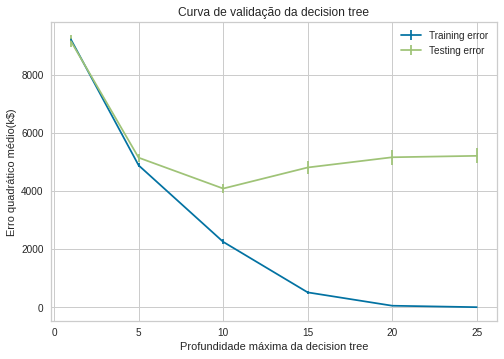

In [71]:
plt.errorbar(max_depth, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label='Training error')
plt.errorbar(max_depth, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label='Testing error')
plt.legend()

plt.xlabel("Profundidade máxima da decision tree")
plt.ylabel("Erro quadrático médio(k$)")
_ = plt.title("Curva de validação da decision tree")

Tivemos sorte a variância dos erros são pequenos em relação aos seus respectivos valores. Portanto as conclusões anteriores são claras. O que nem sempre é o caso.

## Setar e pegar os hiperparâmetros no Scikit-Learning
***

In [72]:
model = make_pipeline(
    StandardScaler(),
    DecisionTreeRegressor(random_state=123)
)
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=123))])

Avaliando a performance estatística do modelo  via validação cruzada.

Podemos mudar o valor de algum  do modelo depois que modelo já tiver sido criado com método, **set_param**.

In [85]:
cv_results = cross_validate(model, data, target, scoring = 'neg_mean_squared_error')
cv_results = pd.DataFrame(cv_results)
cv_results['test_error'] = -cv_results['test_score']
cv_results.head()

,fit_time,score_time,test_score,test_error
0,0.259987,0.003896,-8091.405884,8091.405884
1,0.208969,0.006716,-7502.472731,7502.472731
2,0.507500,0.012990,-8446.147015,8446.147015
3,0.238677,0.005026,-9453.479345,9453.479345
4,0.191556,0.004692,-8488.060473,8488.060473


In [86]:
scores = cv_results['test_error']
print(f"O RMSE via validação cruzada é:\n"
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

O RMSE via validação cruzada é:
8396.313 +/- 710.707


Criamos um modelo aonde padronizamos os dados, e em seguida usamos um estimador de árvore de decisão. Quando usamos um pipeline podemos pegar os steps da seguinte forma:

In [80]:
print(f"Pipeline steps:\n{model.steps}")

Pipeline steps:
[('standardscaler', StandardScaler()), ('decisiontreeregressor', DecisionTreeRegressor(random_state=123))]


Em geral, podemos usar o método **get_params** do scikit-learn para listar todos os parâmetros em cada passo e seus respectivos valores. Para listar todos os parâmetros que existem no pipeline criado, façamos:

In [81]:
for parameter in model.get_params():
    print(parameter)

memory
steps
verbose
standardscaler
decisiontreeregressor
standardscaler__copy
standardscaler__with_mean
standardscaler__with_std
decisiontreeregressor__ccp_alpha
decisiontreeregressor__criterion
decisiontreeregressor__max_depth
decisiontreeregressor__max_features
decisiontreeregressor__max_leaf_nodes
decisiontreeregressor__min_impurity_decrease
decisiontreeregressor__min_impurity_split
decisiontreeregressor__min_samples_leaf
decisiontreeregressor__min_samples_split
decisiontreeregressor__min_weight_fraction_leaf
decisiontreeregressor__random_state
decisiontreeregressor__splitter


**.get_params()** retorna um dicionário aonde as chaves são os nomes dos parâmetros e os valores associados a cada um dos parâmetros. Para acessar um simples parâmetro, por exemplo *"decisiontreeregressor__max_depth"*, podemos usar:

In [87]:
model.set_params(decisiontreeregressor__max_depth = 10)
cv_results = cross_validate(model, data, target, scoring = 'neg_mean_squared_error')
cv_results = pd.DataFrame(cv_results)
cv_results['test_error'] = -cv_results['test_score']
scores = cv_results['test_error']
print(f"O RMSE via validação cruzada é:\n"
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

O RMSE via validação cruzada é:
6625.249 +/- 881.826


In [88]:
max_depth_value = model.get_params()['decisiontreeregressor__max_depth']
print(f"O valor default do max_depth no pipeline criado é: \n {max_depth_value}")

O valor default do max_depth no pipeline criado é: 
 10


In [91]:
for max_depth in [None, 1, 5, 10, 50, 100]:
    model.set_params(decisiontreeregressor__max_depth = max_depth)
    cv_results = cross_validate(model, data, target, scoring = 'neg_mean_squared_error')
    cv_results = pd.DataFrame(cv_results)
    cv_results['test_error'] = -cv_results['test_score']
    scores = cv_results['test_error']
    print(f"O RMSE via validação cruzada com max_depth = {max_depth}:\n"
          f"{scores.mean():.3f} +/- {scores.std():.3f}")

O RMSE via validação cruzada com max_depth = None:
8396.313 +/- 710.707
O RMSE via validação cruzada com max_depth = 1:
9547.850 +/- 827.611
O RMSE via validação cruzada com max_depth = 5:
6658.528 +/- 1026.323
O RMSE via validação cruzada com max_depth = 10:
6625.249 +/- 881.826
O RMSE via validação cruzada com max_depth = 50:
8396.313 +/- 710.707
O RMSE via validação cruzada com max_depth = 100:
8396.313 +/- 710.707


### Warning:
***

Quando avaliamos uma família de modelos nos dados de teste e escolhemos o que performa estatisticamente melhor, nós não podemos mais confiar no score da previsão, e nós precisamos aplicar o modelo selecionado em um novo dado. Como o conjunto de teste foi usado para selecionar o modelo, este não é mais independente do modelo. Para resolver esses problemas é bom separar os dados em treino, teste e validação.